In [2]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## utils

In [4]:
def output_image_size(input_size, filter_size, stride=1, pad=0):
  in_h, in_w = input_size
  filter_h, filter_w = filter_size
  
  out_h = (in_h - filter_h + 2 * pad) / stride + 1
  assert out_h == round(out_h)
  out_w = (in_w - filter_w + 2 * pad) / stride + 1
  assert out_w == round(out_w)
  
  return int(out_h), int(out_w)


def filter_size(input_size, output_size, stride=1, pad=0):
  in_h, in_w = input_size
  out_h, out_w = output_size
  
  filter_h = (in_h + 2 * pad) - stride * (out_h - 1)
  filter_w = (in_w + 2 * pad) - stride * (out_w - 1)
  
  return int(filter_h), int(filter_w)


def im2col_naive(input_data, filter_h, filter_w, stride=1, pad=0):
  in_h, in_w = input_data.shape
  out_h, out_w = output_image_size((in_h, in_w), (filter_h, filter_w), stride, pad)
  
  col = np.zeros((filter_h, filter_w, out_h, out_w))
  for i in range(filter_h):
    for j in range(filter_w):
      col[i, j, :, :] = input_data[i:i+out_h, j:j+out_w]
      
  col = col.reshape(filter_h * filter_w, out_h * out_w)
  
  return col
  

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
  N, C, H, W = input_data.shape
  out_h, out_w = output_image_size((H, W), (filter_h, filter_w), stride, pad)
  
  img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
  col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
  
  for i in range(filter_h):
    i_max = i + stride*out_h
    for j in range(filter_w):
      j_max = j + stride*out_w
      col[:, :, i, j, :, :] = img[:, :, i:i_max:stride, j:j_max:stride]
  
  col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
  return col


def col2im_naive(col, input_shape, output_shape, stride=1, pad=0):
  # col: (out_h * out_w) x (filter_h * filter_w)
  # filter: (filter_h * filter_w) * ( FN )
  in_h, in_w = input_shape
  out_h, out_w = output_shape
  
  filter_h, filter_w = filter_size((in_h, in_w), (out_h, out_w), stride, pad)
  
  col = col.reshape(out_h, out_w, filter_h, filter_w)
  
  image = np.zeros((in_h, in_w))
  
  for i in range(filter_h):
    i_max = i + out_h
    for j in range(filter_w):
      j_max = j + out_w
      image[i:i_max, j:j_max] += col[:, :, i, j]
      
  return image


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
  # col: (N * out_h * out_w) x (C * filter_h * filter_w)
  N, C, H, W = input_shape
  
  out_h, out_w = output_image_size((H, W), (filter_h, filter_w), stride=1, pad=0)
  
  col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
  image = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
  
  for i in range(filter_h):
    i_max = i + stride * out_h
    for j in range(filter_w):
      j_max = j + stride * out_w
      image[:, :, i:i_max:stride, j:j_max:stride] += col[:, :, i, j, :, :]
      
  return image[:, :, pad:H+pad, pad:W+pad]

## functions

In [6]:
# functions.py

def identity_function(x):
  return x


def step_function(x):
  return (x > 0).astype(np.int)


def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
  return sigmoid(x) * sigmoid(1 - x)


def relu(x):
  return np.maximum(x, 0)


def relu_grad(x):
  return step_function(x)


def softmax(x):
  ma = np.max(x, axis=-1, keepdims=True)
  a = np.exp(x - ma)
  return a / np.sum(a, axis=-1, keepdims=True)


def sum_squared_error(y, t):
  return np.sum((y - t)**2) * 0.5


def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape((1, t.size))
    y = y.reshape((1, y.size))
  
  if y.size == t.size:
    t = t.argmax(axis=1)
    
  batch_size = y.shape[0]
  return -np.sum(np.log(y[:, t] + 1e-7)) / batch_size


def softmax_loss(X, t):
  y = softmax(X)
  return cross_entropy_error(y, t)

## layers

In [7]:
# layers.py
# https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/common/layers.py

class Layer:
  def __init__(self):
    pass
  
  def forward(self, x):
    pass
  
  def backward(self, dout):
    pass


class Sigmoid(Layer):
  def __init__(self):
    self.out = None
    
  def forward(self, x):
    out = sigmoid(x)
    self.out = out
    return out
  
  def backward(self, dout):
    dx = dout * self.out * (1 - self.out)
    return dx
  
  
class Relu(Layer):
  def __init__(self):
    self.mask = None
    
  def forward(self, x):
    self.mask = x < 0
    out = np.maximum(x, 0)
    return out
  
  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx
  
  
class Affine(Layer):
  def __init__(self, W, b):
    self.W = W
    self.b = b
    
    self.x = None
    self.original_x_shape = None
    
    self.dW = None
    self.db = None
    
  def forward(self, x):
    self.original_x_shape = x.shape  # テンソル対応?
    x = x.reshape(x.shape[0], -1)
    self.x = x
    
    out = self.x @ self.W + self.b
    return out
  
  def backward(self, dout):
    dx = dout @ self.W.T
    self.dW = self.x.T @ dout
    self.db = np.sum(dout, axis=0)
    
    dx = dx.reshape(*self.original_x_shape)
    return dx
  

class SoftmaxWithLoss(Layer):
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None
    
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[:, t] -= 1
      dx /= batch_size
    
    return dx

  
class Dropout(Layer):
  def __init__(self, dropout_ratio=0.5):
    super.__init__()
    self.dropout_ratio = dropout_ratio
    self.mask = None
    
  def forward(self, x, train_flag=True):
    if train_flag:
      self.mask = np.random.rand(*x.shape) > dropout_ratio
      return x * self.mask
    else:
      return x * (1 - self.dropout_ratio)
  
  def backward(self, dout):
    return dout * self.mask
  

class BatchNormalization:
  def __init__(self, gamma, beta):
    self.params = [gamma, beta]
    self.grads = [np.zeros_like(gamma), np.zeros_like(beta)]
    self.cache = None
    
  def forward(self, x):
    N, D = x.shape
    gamma, beta = self.params
    
    mu = np.mean(x, axis=0)
    xc = x - mu
    var = np.mean(xc**2, axis=0)
    std = np.sqrt(var + 1e-7)
    xn = xc / std
    
    out = gamma * xn + beta
    
    self.cache = (xc, std, xn)
    
    return out
  
  def backward(self, dout):
    N, D = dout.shape
    gamma, beta = self.params
    xc, std, xn = self.cache
    
    dbeta = np.sum(dz, axis=0)
    dgamma = np.sum(dz * xn, axis=0)
    dxn = dout * gamma
    dxc = dxn / std
    dstd = -np.sum(dxn * xc, axis=0) / std**2
    dvar = 0.5 * dstd / std
    dxc += 2 * dvar * xc / N
    dmu = np.sum(-dxc, axis=0)
    dx = dxc + dmu / N
    
    self.grads[0][...] = dgamma
    self.grads[1][...] = dbeta
    
    return dx
  

class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.params = [W, b]
    self.grads = [np.zeros_like(W), np.zeros_like(b)]
    self.stride = stride
    self.pad = pad
    self.cache = None
    
  def forward(self, x):
    N, C, H, W = x.shape
    W, b = self.params
    FN, C, FH, FW = W.shape
    
    OH, OW = output_image_size((H, W), (FH, FW), self.stride, self.pad)
    
    col = im2col(x, FH, FW, self.stride, self.pad)
    col_W = W.reshape(FN, -1).T
    out = col @ col_W + b
    out = out.reshape(N, OH, OW, -1).transpose(0, 3, 1, 2)
    
    self.cache = (x, col, col_W)
    
    return out
  
  def backward(self, dout):
    W, b = self.params
    FN, C, FH, FW = W.shape
    x, col, col_W = self.cache
    
    dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
    
    db = np.sum(dout, axis=0)
    dW = col.T @ dout
    dW = dW.T.reshape(FN, C, FH, FW)
    dcol = dout @ col_W.T
    
    dx = col2im(col, x.shape, FH, FW, self.stride, self.pad)
    return dx
  
  
class Pooling:
  def __init__(self, pool_h, pool_w, stride=2, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad
    
    self.cache = None
    
  def forward(self, x):
    N, C, H, W = x.shape
    
    OH, OW = output_image_size((H, W), (self.pool_h, self.pool_w), self.stride, self.pad)
    
    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h * self.pool_w)
    
    arg_max = np.argmax(col, axis=1)
    out = np.max(col, axis=1)
    out = out.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
    
    self.cache = (x, arg_max)
    
    return out
  
  def backward(self, dout):
    N, C, OH, OW = dout.shape
    x, arg_max = self.cache
    
    dout  = dout.transpose(0, 2, 3, 1)
    
    dmax = np.zeros((dout.size, self.pool_h * self.pool_w))
    dmax[np.arange(dout.size), arg_max.flatten()] = dout.flatten()
    dmax = dmax.reshape(dout.shape + (self.pool_h * self.pool_w,))
    
    dcol = dmax.reshape(N * OH * OW, -1)
    dx = col2im(dcol, x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
    
    return dx

## optimizers

In [8]:
# optimizer.py

class Optimizer:
  def __init__(self):
    pass
  
  def update(self, params, grads):
    pass
  

class SGD(Optimizer):
  def __init__(self, lr=0.01):
    super.__init__()
    self.lr = lr
    
  def update(self, params, grads):
    for key in params.keys():
      params[key] = params[key] - self.lr * grads[key]
      

class Momentum(Optimizer):
  def __init__(self, lr=0.01, momentum=0.9):
    super.__init__()
    self.lr = lr
    self.momentum = momentum
    self.v = None
    
  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in  params.items():
        self.v[key] = np.zeros_like(val)
        
    for key in params.keys():
      self.v[key] = self.momentum * self.v - self.lr * grads[key]
      params[key] += self.v
      
      
class AdaGrad(Optimizer):
  def __init__(self, lr=0.01):
    super.__init__()
    self.lr = lr
    self.h = None
    
  def update(self, params, grads):
    if h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)
        
    for key in params.keys():
      self.h[key] += grads[key]**2
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
      
      
class RMSProp(Optimizer):
  def __init__(self, lr=0.01, decay_rate=0.99):
    super.__init()
    self.lr = lr
    self.decay_rate = decay_rate
    self.h = None
    
  def update(self, params, grads):
    if h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)
        
    for key in params.keys():
      self.h[key] = self.decay_rate * self.h[key] + (1 - self.decay_rate) * grads[key]**2
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)    
      
      
class Adam(Optimizer):
  def __init__(self, lr=0.001, beta1=0.99, beta2=0.999):
    super.__init__()
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.v = None
    self.h = None
    
  def update(self, params, grads):
    if v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)
        
    if h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)
    
    self.iter += 1
    lr_t = self.lr * np.sqrt(1 - self.beta2 ** self.iter) / np.sqrt(1 - self.beta1 ** self.iter)
    
    for key in params.keys():
      self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * grads[key]
      self.h[key] = self.beta2 * self.h[key] + (1 - self.beta2) * grads[key]**2
      params[key] -= lr_t * self.v[key] / np.sqrt(self.h[key] + 1e-7)

## networks

In [9]:
class SimpleConvNet:
  """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
  """
  def __init__(self, input_shape=(1,28,28), 
               conv_params={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
               hidden_size=100, output_size=10, weight_init_std=0.01):
    
    FN = conv_params['filter_num']
    FH = FW = conv_params['filter_size']
    pad = conv_params['pad']
    stride = conv_params['stride']
    C, H, W = input_shape
    
    conv_output_h = (H - FH + 2 * pad) / stride + 1
    conv_output_w = (W - FW + 2 * pad) / stride + 1
    pooling_output_h = conv_output_h / 2
    pooling_output_w = conv_output_w / 2
    
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(FN, C, FH, FW)
    self.params['b1'] = np.zeros(FN)
    self.params['W2'] = weight_init_std * np.random.randn(FN * pooling_output_h * pooling_output_w, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)
    
    self.layers = OrderedDict()
    self.layers['Conv1'] = CNN(self.params['W1'], self.params['b1'], stride, pad)
    self.layers['Relu1'] = Relu()
    self.layers['Pooling1'] = Pooling(pooling_output_h, pooling_output_w, stride=2)
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
    
    self.lastlayer = SoftmaxWithLoss()
  
  
  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    
    return x
  
  
  def loss(self, x, t):
    x = self.predict(x)
    return self.lastyear.forward(x, t)
  
  
  def accuracy(self, x, t, batch_size=100):
    acc = 0
    
    N = x.shape[0]
    for i in range(N // batch_size):
      tmp_x = x[i * batch_size : (i+1) * batch_size]
      tmp_t = t[i * batch_size : (i+1) * batch_size]
      y = self.predict(x)
      y = np.argmax(y, axis=1)
      acc += np.sum(y == tmp_t)
    
    acc /= N
    return acc
  
  
  def gradient(self, x, t):
    # forward
    self.loss(x, t)
    
    # backward
    dout = 1
    dout = self.lastlayer.backward(dout)
    
    for layer in reversed(list(self.layers.values())):
      dout = layer.backward(dout)
      
    grads = {}
    grads['W1'] = self.layers['Conv1'].dW
    grads['b1'] = self.layers['Conv1'].db
    grads['W2'] = self.layers['Affine1'].dW
    grads['b2'] = self.layers['Affine1'].db
    grads['W3'] = self.layers['Affine2'].dW
    grads['b3'] = self.layers['Affine2'].db
    
    return grads

## others

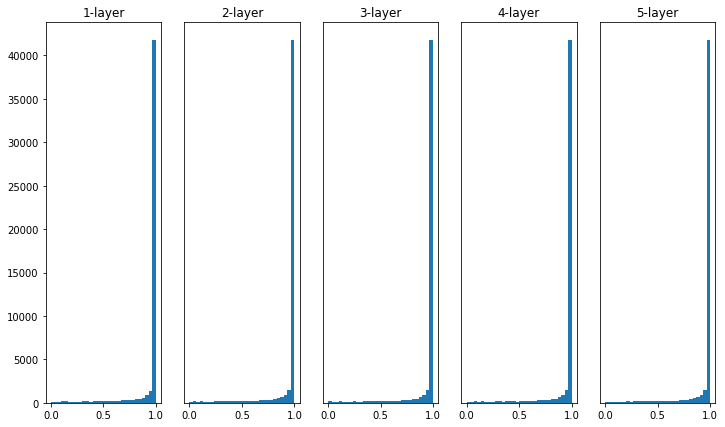

In [10]:
# weight_init_activation_histogram.py

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(x, 0)

def tanh(x):
  return np.tanh(x)


input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

x = input_data

for i in range(hidden_layer_size):
  if i != 0:
    x = activations[i-1]
    
  w = np.random.randn(node_num, node_num) * 1
  z = np.dot(x, w)
  a = tanh(z)
  activations[i] = a


plt.figure(figsize=(12,7))
for i, a in activations.items():
  plt.subplot(1, len(activations), i+1)
  plt.title(f"{i+1}-layer")
  
  if i != 0: plt.yticks([], [])
  
  plt.hist(a.flatten(), bins=30, range=(0,1))